In [27]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode

import math
import random
import sys
import h5py
from scipy.io import savemat
import configparser

setpaths_dir = "../setpaths"
sys.path.append(setpaths_dir)
from setpaths import setpaths
libpath, datpath, resultpath, basepath = setpaths(setpaths_dir)

sys.path.append(basepath)
from lib.DOTDataset_class import DOTDataset
from lib.utils import train_model, showIms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
rand_seed = 0
np.random.seed(rand_seed)
torch_seed = torch.manual_seed(rand_seed)

GPUID = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPUID)

In [29]:
# Set parameters
# configname = "unet_vgg_train_fashion_test_fashion.ini"
# configname = "train_fashion_test_fashion.ini"
# configname = "train_fashion_test_mnist.ini"
configname = "train_mnist_test_mnist.ini"

fullconfigpath = os.path.join("settings", configname)
config = configparser.ConfigParser()
_ = config.read(fullconfigpath)

# Forward model parameters
jac_dir = config["Settings"]["jac_dir"]
abs_mua = float(config["Settings"]["abs_mua"])
bin_sz = int(config["Settings"]["bin_sz"])
int_time = float(config["Settings"]["int_time"]) # Seconds
pile_up = float(config["Settings"]["pile_up"]) # Pile-up point in cnts/sec

train_set_select = config["Settings"]["train_set_select"] # 'f' for fashion mnist
test_set_select = config["Settings"]["test_set_select"] # 'm' for mnist

# Training parameters
nTrain = int(config["Settings"]["nTrain"])
nTest = int(config["Settings"]["nTest"])
batch_sz = int(config["Settings"]["batch_sz"])
nLayers = int(config["Settings"]["nLayers"])
LR = float(config["Settings"]["LR"])
scale_initial_val = LR
nEpochs = int(config["Settings"]["nEpochs"])
lam1 = config.get("Settings", "lam1", fallback=None) # if None use learnable L1 coefficient, else use lam1
untied = config["Settings"].getboolean("untied")
showEvery = int(config["Settings"]["showEvery"])
lossFunc = config["Settings"]["lossFunc"]
vgg_weight = float(config["Settings"]["vgg_weight"])
unet_nfilts = int(config["Settings"]["unet_nfilts"])
displayIndices = [int(i) for i in config["Settings"]["displayIndices"].split(',')]
measNormalization = float(config["Settings"]["measNormalization"])

RUN_DEBUG = True
debug_vis_inds = displayIndices

In [31]:
# Load in Jacobian
J_full_fname = "%s/%s/J_multisrc_interp.mat" % (datpath, jac_dir)  # Load in Jacobian

# J_full_fname = "%s/%s/J.mat" % (datpath, jac_dir)

import h5py

with h5py.File(J_full_fname, 'r') as f:
    print("Keys in file:", list(f.keys()))

with h5py.File(J_full_fname, 'r') as f:
    print("Jheaders keys:", list(f["Jheaders"].keys()))


with h5py.File(J_full_fname, 'r') as f:
    J = f["J_final"][:]
    vox_sidelen = f["Jheaders"]["VOX_SIDELEN"][0][0]
    SRC_W = f["Jheaders"]["SRC_W"][0][0]
    SRC_L = f["Jheaders"]["SRC_L"][0][0]
    TIME_MAX = f["Jheaders"]["TIME_MAX"][0][0]
    TIME_MIN = f["Jheaders"]["TIME_MIN"][0][0]

    # bkg_sig = None
    # if "bkg_final" in f:
    #     bkg_sig = f["bkg_final"][:]

    bkg_sig = f["bkg_final"][:]

J = torch.tensor(np.transpose(J, np.flip(range(len(J.shape)))),
                 dtype=torch.float)  # Invert dimensions in importing from matlab
bkg_sig = torch.tensor(np.transpose(bkg_sig, np.flip(range(len(bkg_sig.shape)))), dtype=torch.float)
NBINS, SRC_W, SRC_L, DET_W, DET_L, VOX_W, VOX_L = J.shape
DTIME = (TIME_MAX - TIME_MIN) / NBINS
timeAx = torch.arange(TIME_MIN, TIME_MAX, DTIME) + (DTIME / 2.)

Keys in file: ['#refs#', '#subsystem#', 'J_final', 'Jheaders', 'SRC_L', 'SRC_W', 'bkg_final', 'fullBkgPath', 'fullJpath', 'params']
Jheaders keys: ['NBINS', 'NORMALIZETPSF', 'NUM_ITERS', 'NUM_SAMPS', 'SCAT_VEC', 'SENS_DIM', 'SENS_L', 'SENS_ORIG', 'SENS_ORIGX', 'SENS_ORIGY', 'SENS_ORIGZ', 'SENS_PIXW', 'SENS_SEP', 'SENS_W', 'SRC_DIM', 'SRC_L', 'SRC_ORIG', 'SRC_ORIGX', 'SRC_ORIGY', 'SRC_ORIGZ', 'SRC_SEP', 'SRC_W', 'TIME_MAX', 'TIME_MIN', 'VOX_DIM', 'VOX_H', 'VOX_L', 'VOX_ORIG', 'VOX_ORIGX', 'VOX_ORIGY', 'VOX_ORIGZ', 'VOX_SIDELEN', 'VOX_W', 'VOX_ZLEN']


Done loading datasets!


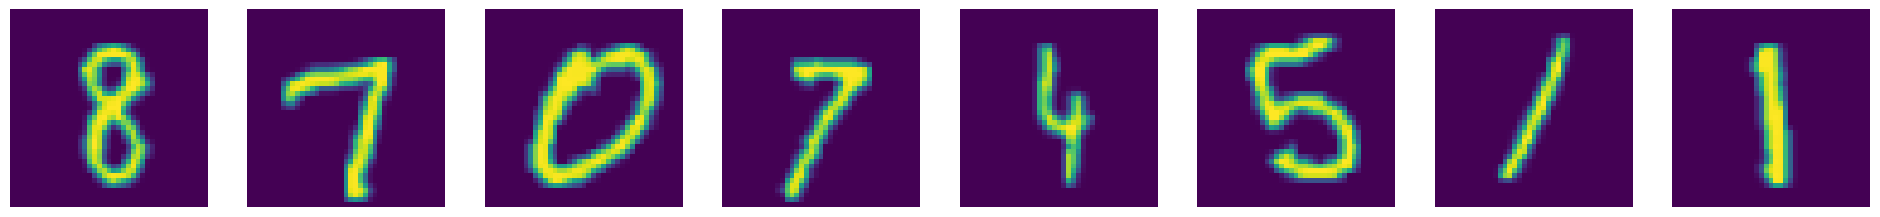

In [32]:
# Load in datasets (MNIST and Fashion MNIST)

mnist_full_set = datasets.MNIST(
    root=datpath,
    train=True,
    download=True,
    transform=ToTensor(),
)

fashion_full_set = datasets.FashionMNIST(
    root=datpath,
    train=False,
    download=True,
    transform=ToTensor()
)

print("Done loading datasets!")

len_mnist = len(mnist_full_set)
len_fashion = len(fashion_full_set)

fashion_inds = torch.randperm(len_fashion)
mnist_inds = torch.randperm(len_mnist)

fashion_set_shuffled = fashion_full_set.data[fashion_inds,:,:]
mnist_set_shuffled = mnist_full_set.data[mnist_inds,:,:]

# Process images so they are properly sized and max intensity equal to mu_a
f_resize = Resize((VOX_W, VOX_L))

if train_set_select.lower() == 'f':
    train_dat = f_resize(fashion_set_shuffled[:nTrain,:,:].double())
elif train_set_select.lower() == 'm':
    train_dat = f_resize(mnist_set_shuffled[:nTrain,:,:].double())
    
if test_set_select.lower() == 'f':
    test_dat = f_resize(fashion_set_shuffled[nTrain:(nTrain+nTest)].double())
elif test_set_select.lower() == 'm':
    test_dat = f_resize(mnist_set_shuffled[nTrain:(nTrain+nTest)].double())

final_recon_vis = np.transpose(np.concatenate([train_dat[debug_vis_inds,:,:], test_dat[debug_vis_inds,:,:]]), (1,2,0))
showIms(final_recon_vis)

test_dat *= (abs_mua / torch.amax(test_dat, dim=(1,2)))[:,None,None]
train_dat *= (abs_mua / torch.amax(train_dat, dim=(1,2)))[:,None,None]

In [33]:
# Generate noisy measurements

nbins_final = math.ceil(NBINS / bin_sz)

J_binned = torch.zeros((nbins_final, SRC_W, SRC_L, DET_W, DET_L, VOX_W, VOX_L))
bkg_binned = torch.zeros((nbins_final, SRC_W, SRC_L, DET_W, DET_L))
for t in range(nbins_final):
    t_start = t*bin_sz
    t_end = min((t+1)*bin_sz, NBINS)
    J_binned[t,:,:,:,:,:,:] = torch.sum(J[t_start:t_end,:,:,:,:,:,:], dim=0)
    bkg_binned[t,:,:,:,:] = torch.sum(bkg_sig[t_start:t_end,:,:,:,:], dim=0)

# Reshape Jacobian to be able to multiply with images
nvox = np.prod([VOX_W, VOX_L])
nsrcdet = np.prod([SRC_W, SRC_L, DET_W, DET_L])
J_mat = torch.reshape(J_binned, (nbins_final, SRC_W, SRC_L, DET_W, DET_L, nvox)).double()

# Reshape images
test_mu = torch.transpose(torch.reshape(test_dat, (-1, nvox)), 0, 1)
train_mu = torch.transpose(torch.reshape(train_dat, (-1, nvox)), 0, 1)

# Generate clean measurements: J*mu
m_test_clean = J_mat @ test_mu
m_train_clean = J_mat @ train_mu

# Calculate normalization factor: integrate bkg in time domain, find the max
normfac = (int_time * pile_up) / torch.amax(torch.sum(bkg_binned,0))

# replicate bkg by number of samples, 
bkg_clean_test = bkg_binned[:,:,:,:,:,None].repeat((1,1,1,1,1,nTest))
bkg_clean_train = bkg_binned[:,:,:,:,:,None].repeat((1,1,1,1,1,nTrain))

# Measurement is bkg - J*mu
abs_clean_test = torch.clip(bkg_clean_test - m_test_clean, min=0, max=None)
abs_clean_train = torch.clip(bkg_clean_train - m_train_clean, min=0, max=None)

# Scale the max background to be int_time*pile_up
bkg_clean_test_norm = bkg_clean_test * normfac
bkg_clean_train_norm = bkg_clean_train * normfac
abs_clean_test_norm = abs_clean_test * normfac
abs_clean_train_norm = abs_clean_train * normfac

# Apply poisson noise then take the difference
bkg_noisy_test = torch.poisson(bkg_clean_test_norm)
bkg_noisy_train = torch.poisson(bkg_clean_train_norm)
abs_noisy_test = torch.poisson(abs_clean_test_norm)
abs_noisy_train = torch.poisson(abs_clean_train_norm)

m_noisy_test_raw = bkg_noisy_test - abs_noisy_test
m_noisy_train_raw = bkg_noisy_train - abs_noisy_train
m_noisy_test_norm = m_noisy_test_raw / normfac
m_noisy_train_norm = m_noisy_train_raw / normfac
m_noisy_test = torch.reshape(m_noisy_test_norm, (-1, nTest))
m_noisy_train = torch.reshape(m_noisy_train_norm, (-1, nTrain))

# Prepare Jacobian matrix
J_mat_np = torch.reshape(J_mat, (nbins_final*nsrcdet, nvox)).cpu().detach().numpy()

In [34]:
# Prepare model for training

test_noisy_dat = torch.reshape(m_noisy_test, (nbins_final, nsrcdet, nTest)).cpu().detach().numpy()
train_noisy_dat = torch.reshape(m_noisy_train, (nbins_final, nsrcdet, nTrain)).cpu().detach().numpy()
test_truth = torch.permute(test_dat, (1,2,0)).cpu().detach().numpy()
train_truth = torch.permute(train_dat, (1,2,0)).cpu().detach().numpy()

test_noisy_dat *= measNormalization / np.amax(test_noisy_dat)
train_noisy_dat *= measNormalization / np.amax(train_noisy_dat)
full_dataset = DOTDataset(trainMeas=train_noisy_dat, trainTruth=train_truth, testMeas=test_noisy_dat, testTruth=test_truth)

All Training Images Match!
All Testing Images Match!


Found no overlaps!


Visualize collocated measurements
test measurements
Tot # of background photons: 1.00e+06


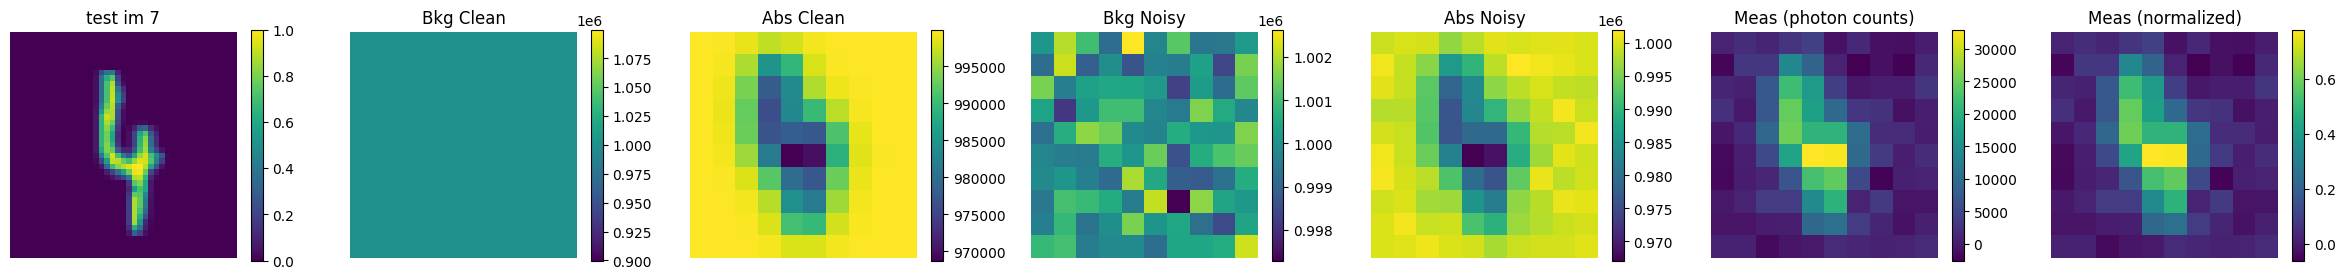

test measurements
Tot # of background photons: 1.00e+06


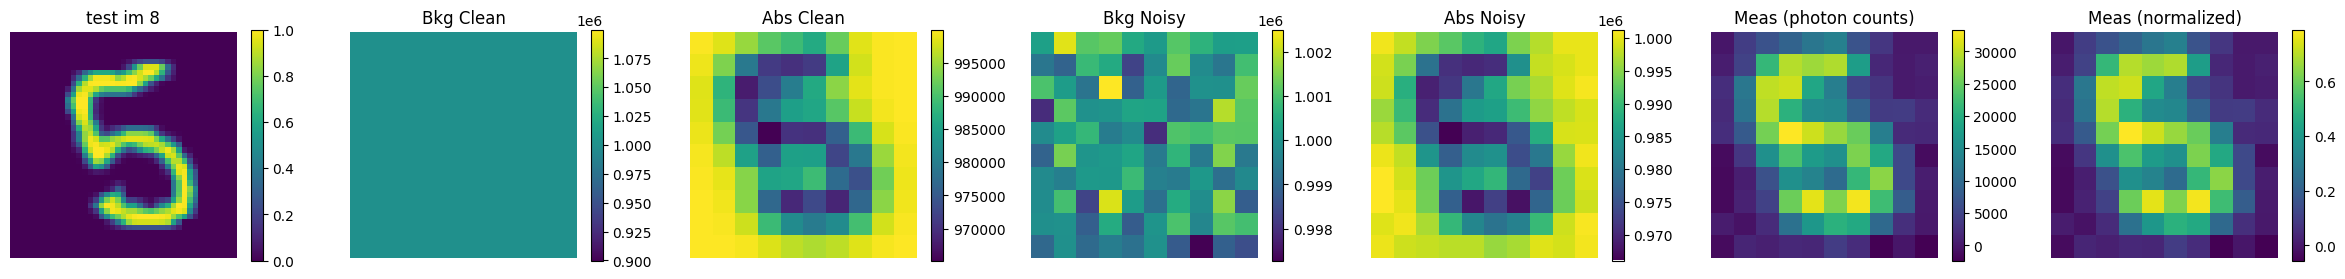

test measurements
Tot # of background photons: 1.00e+06


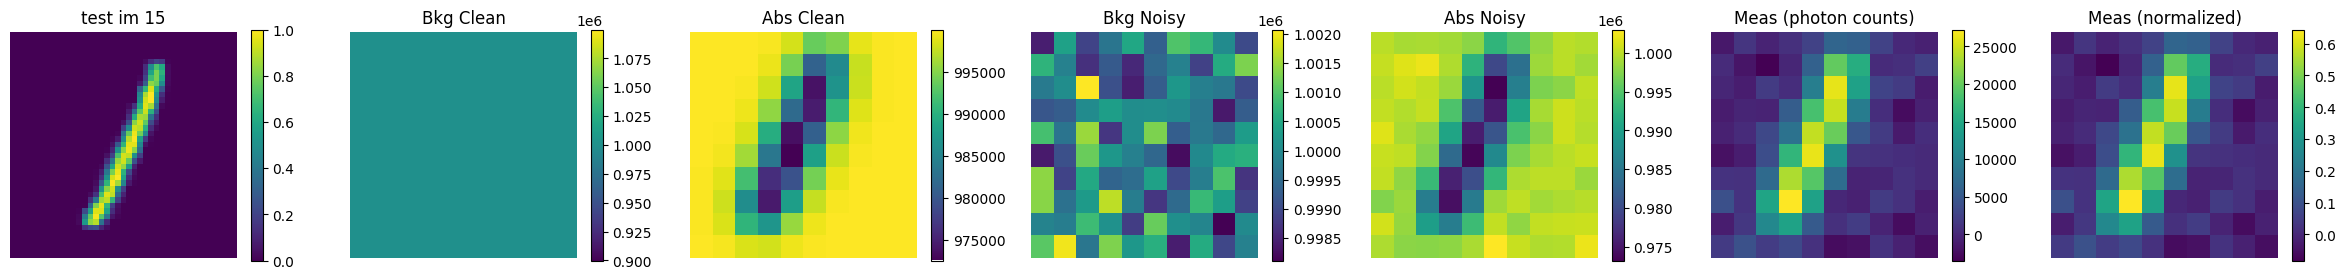

test measurements
Tot # of background photons: 1.00e+06


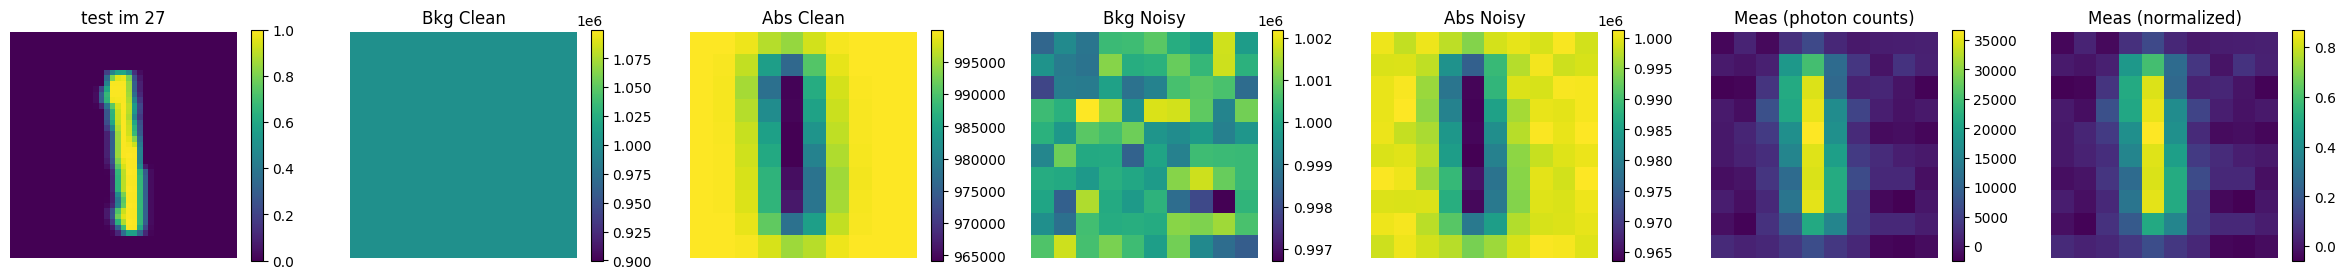

train measurements
Tot # of background photons: 1.00e+06


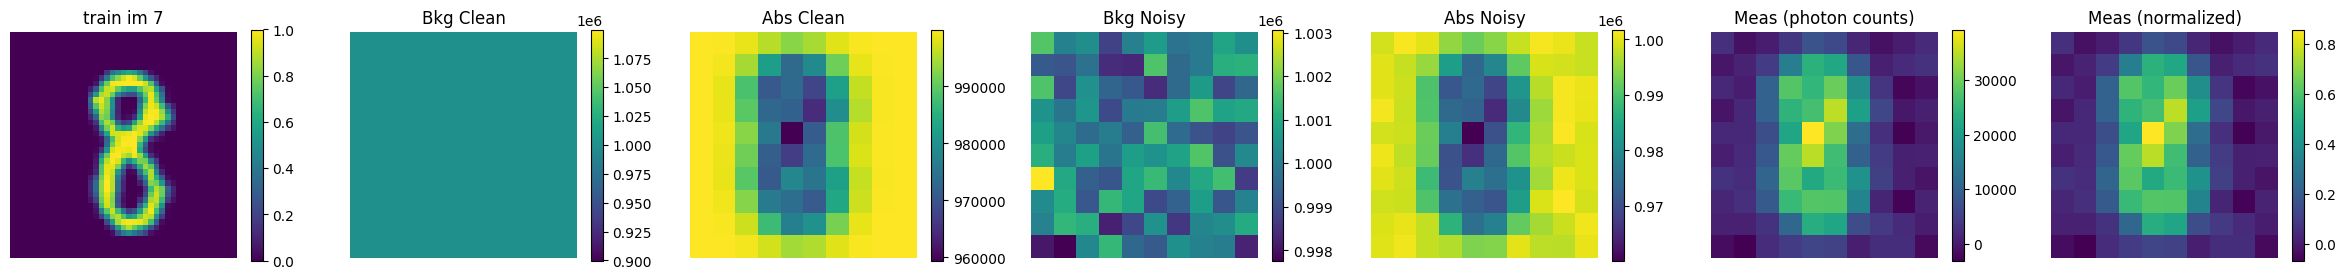

train measurements
Tot # of background photons: 1.00e+06


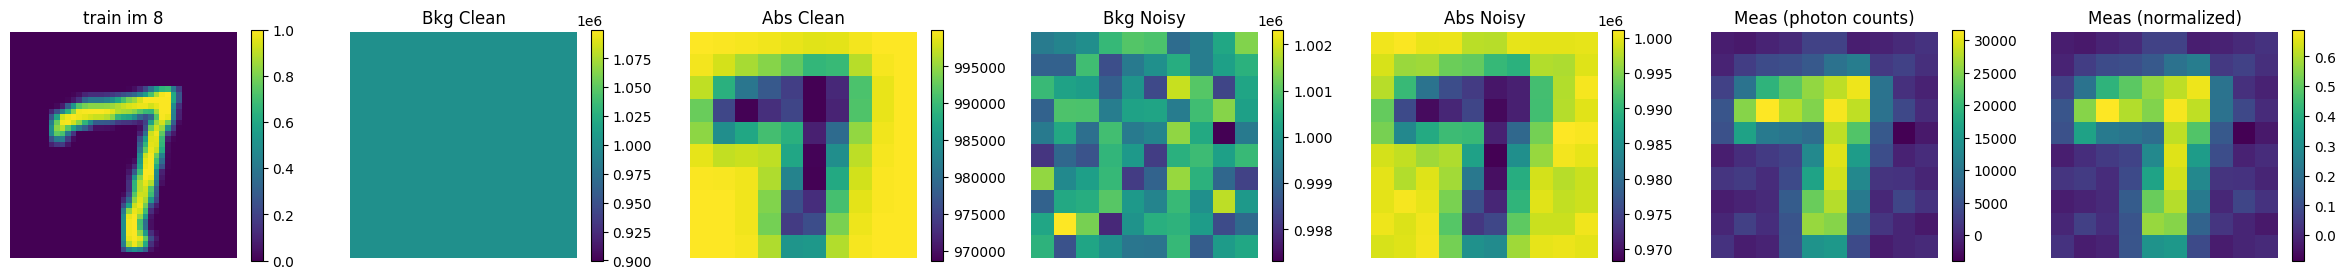

train measurements
Tot # of background photons: 1.00e+06


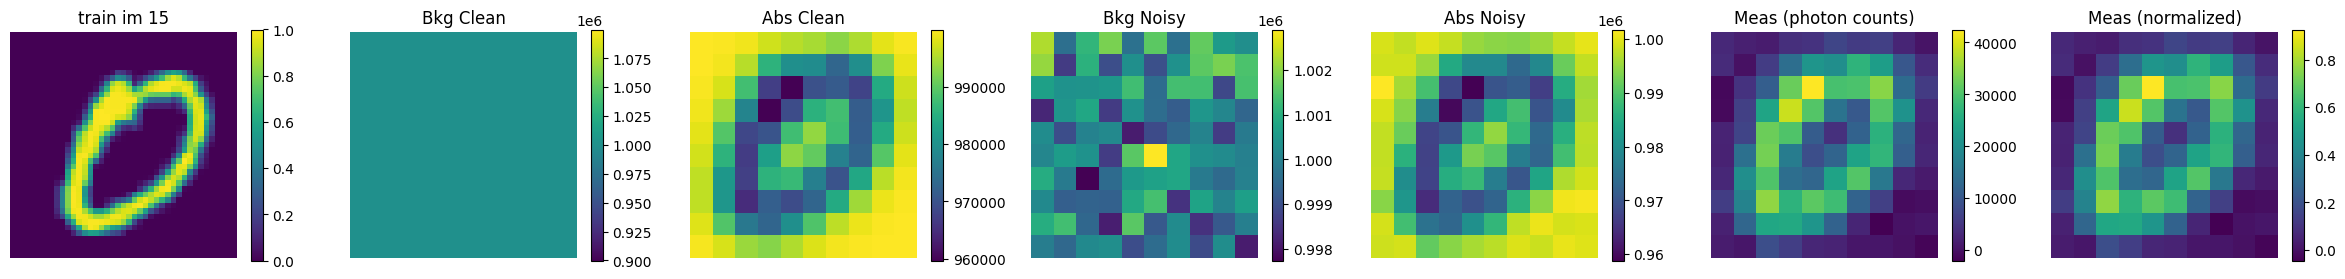

train measurements
Tot # of background photons: 1.00e+06


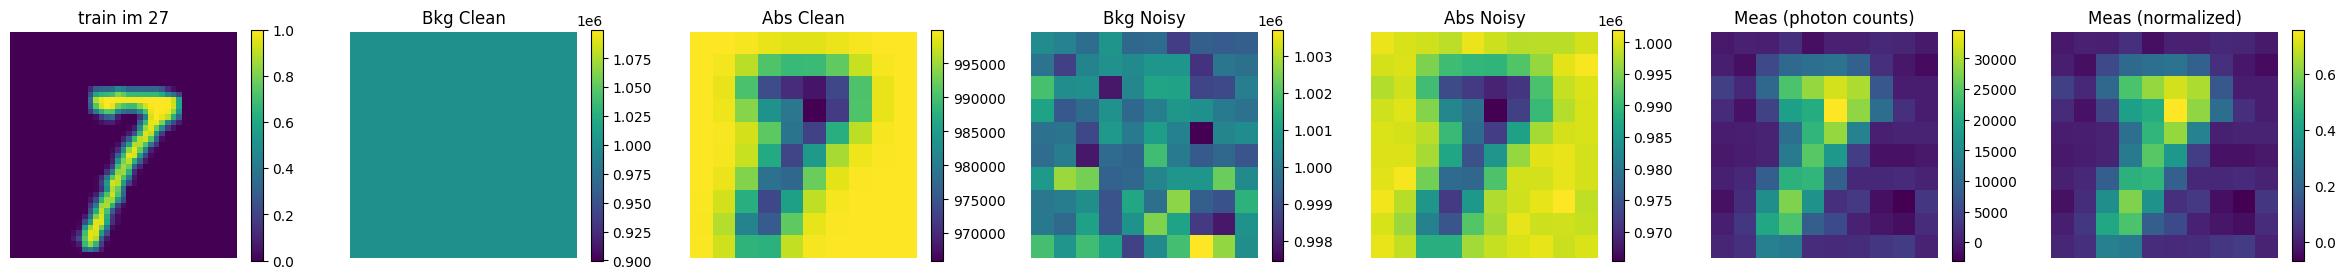



Visualize training and test sets


/opt/anaconda3/envs/unrolled-dot-env/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/opt/anaconda3/envs/unrolled-dot-env/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/opt/anaconda3/envs/unrolled-dot-env/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ imple

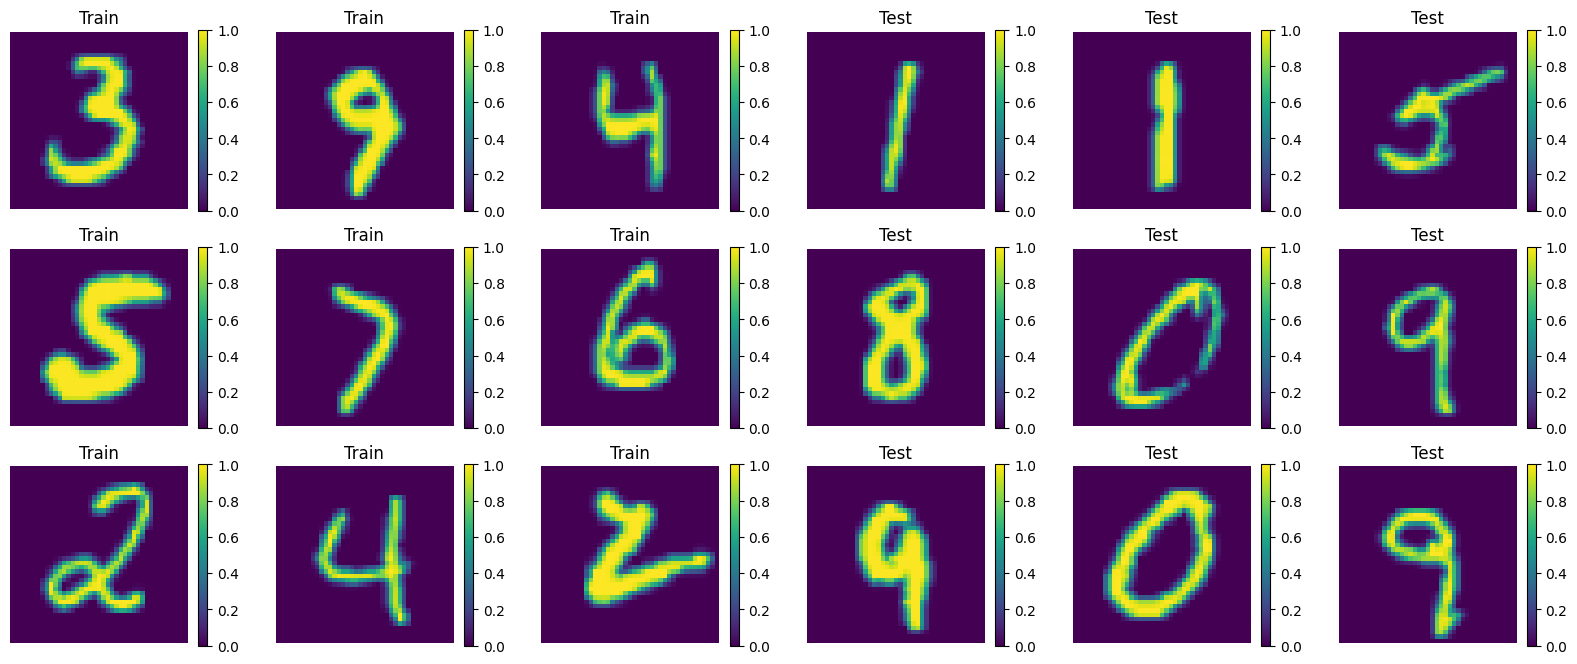

In [35]:
if RUN_DEBUG:
    with torch.no_grad():
       
        trainMeas, trainTruth = full_dataset.getFullTrainSet()
        testMeas, testTruth = full_dataset.getFullTestSet()
        
        # Test that training images correctly corresponds to mnist, fashion mnist image
        if train_set_select.lower() == 'm':
            full_set_train = mnist_full_set.data[mnist_inds,:,:]
        elif train_set_select.lower() == 'f':
            full_set_train = fashion_full_set.data[fashion_inds,:,:]
        for train_i in range(nTrain):
            allDat_im = np.reshape(trainTruth[:,train_i].cpu().detach().numpy(), (VOX_W, VOX_L))
            train_im = np.reshape(f_resize(full_set_train[train_i].double()[None,:,:]).cpu().detach().numpy(), (VOX_W, VOX_L)) 
            allDat_im /= np.amax(allDat_im)
            train_im /= np.amax(train_im)
            assert (np.allclose(allDat_im, train_im)), "Training images do not match!"
        print("All Training Images Match!")
    
        if test_set_select.lower() == 'm':
            full_set_test = mnist_full_set.data[mnist_inds,:,:]
        elif test_set_select.lower() == 'f':
            full_set_test = fashion_full_set.data[fashion_inds,:,:]
        for test_i in range(nTest):
            allDat_im = np.reshape(testTruth[:,test_i].cpu().detach().numpy(), (VOX_W, VOX_L))
            test_im = np.reshape(f_resize(full_set_test[nTrain+test_i].double()[None,:,:]).cpu().detach().numpy(), (VOX_W, VOX_L))
            allDat_im /= np.amax(allDat_im)
            test_im /= np.amax(test_im)
            assert (np.allclose(allDat_im, test_im)), "Testing images do not match!"
        print("All Testing Images Match!")
        print("\n")
    
        # Ensure no overlap
        train_ims_check = trainTruth
        test_ims_check = testTruth
        for p in range(nTest):
            im_p_test = torch.reshape(test_ims_check[:,p], (VOX_W, VOX_L))
            for q in range(nTrain):
                im_q_train = torch.reshape(train_ims_check[:,q], (VOX_W, VOX_L))
                assert (not torch.allclose(im_p_test, im_q_train)), "Found Overlap"
        print("Found no overlaps!")
        print("\n")
    
        # Visualize collocated measurements
        print("Visualize collocated measurements")
        for j in range(2): # Training and test
            for i in range(len(debug_vis_inds)):
                if j == 0:
                    bkg_clean = bkg_clean_test_norm[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    abs_clean = abs_clean_test_norm[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    bkg_noisy = bkg_noisy_test[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    abs_noisy = abs_noisy_test[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    m_noisy_raw = m_noisy_test_raw[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    m_noisy_norm = m_noisy_test_norm[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    truth_debug = test_truth[:,:,debug_vis_inds[i]]
                    title_str = "test"
                else:
                    bkg_clean = bkg_clean_train_norm[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    abs_clean = abs_clean_train_norm[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    bkg_noisy = bkg_noisy_train[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    abs_noisy = abs_noisy_train[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    m_noisy_raw = m_noisy_train_raw[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    m_noisy_norm = m_noisy_train_norm[:,:,:,:,:,debug_vis_inds[i]].cpu().detach().numpy()
                    truth_debug = train_truth[:,:,debug_vis_inds[i]]
                    title_str = "train"
                
                print("%s measurements" % title_str)
                # Generate colocated measurements
                bkg_clean_coloc = np.zeros((SRC_W, SRC_L))
                abs_clean_coloc = np.zeros((SRC_W, SRC_L))
                bkg_noisy_coloc = np.zeros((SRC_W, SRC_L))
                abs_noisy_coloc = np.zeros((SRC_W, SRC_L))
                m_noisy_raw_coloc = np.zeros((SRC_W, SRC_L))
                m_noisy_norm_coloc = np.zeros((SRC_W, SRC_L))
                
                for sc in range(SRC_W):
                    for sr in range(SRC_L):
                        bkg_clean_coloc[sc, sr] = np.sum(bkg_clean[:,sc,sr,sc,sr])
                        abs_clean_coloc[sc, sr] = np.sum(abs_clean[:,sc,sr,sc,sr])
                        bkg_noisy_coloc[sc, sr] = np.sum(bkg_noisy[:,sc,sr,sc,sr])
                        abs_noisy_coloc[sc, sr] = np.sum(abs_noisy[:,sc,sr,sc,sr])
                        m_noisy_raw_coloc[sc, sr] = np.sum(m_noisy_raw[:,sc,sr,sc,sr])
                        m_noisy_norm_coloc[sc, sr] = np.sum(m_noisy_norm[:,sc,sr,sc,sr])
                
                title_str_full = "%s im %d" % (title_str, debug_vis_inds[i])
                print("Tot # of background photons: %.2e" % (int_time * pile_up))
                plt.figure(figsize=(30,3))
                plt.subplot(1,7,1)
                plt.imshow(truth_debug)
                plt.title(title_str_full)
                plt.axis("off")
                _ = plt.colorbar()
                plt.subplot(1,7,2)
                plt.imshow(bkg_clean_coloc)
                plt.title("Bkg Clean")
                plt.axis("off")
                _ = plt.colorbar()
                plt.subplot(1,7,3)
                plt.imshow(abs_clean_coloc)
                plt.title("Abs Clean")
                plt.axis("off")
                _ = plt.colorbar()
                plt.subplot(1,7,4)
                plt.imshow(bkg_noisy_coloc)
                plt.title("Bkg Noisy")
                plt.axis("off")
                _ = plt.colorbar()
                plt.subplot(1,7,5)
                plt.imshow(abs_noisy_coloc)
                plt.title("Abs Noisy")
                plt.axis("off")
                _ = plt.colorbar()
                plt.subplot(1,7,6)
                plt.imshow(m_noisy_raw_coloc)
                plt.title("Meas (photon counts)")
                plt.axis("off")
                _ = plt.colorbar()
                plt.subplot(1,7,7)
                plt.imshow(m_noisy_norm_coloc)
                plt.title("Meas (normalized)")
                plt.axis("off")
                _ = plt.colorbar()
                plt.show()
        print("\n")
                
                
        # Visualize training and test sets
        print("Visualize training and test sets")
        figure = plt.figure(figsize=(20, 8))
        cols, rows = 6, 3
        ncols_per_class = 3
        train_rand_inds = random.sample(range(nTrain), rows*ncols_per_class)
        test_rand_inds = random.sample(range(nTest), rows*ncols_per_class)
        train_k = 0
        test_k = 0
        for i in range(1, cols * rows + 1):
            if (((i-1) % cols) // ncols_per_class) > 0:
                img = testTruth[:,test_rand_inds[test_k]]
                im_title = "Test"
                test_k += 1
            else:
                img = trainTruth[:,train_rand_inds[train_k]]
                im_title = "Train"
                train_k += 1
            img = torch.reshape(img, (VOX_W, VOX_L))
            figure.add_subplot(rows, cols, i)
            plt.axis("off")
            plt.title(im_title)
            plt.imshow(img.squeeze())
            plt.colorbar()
        plt.show()

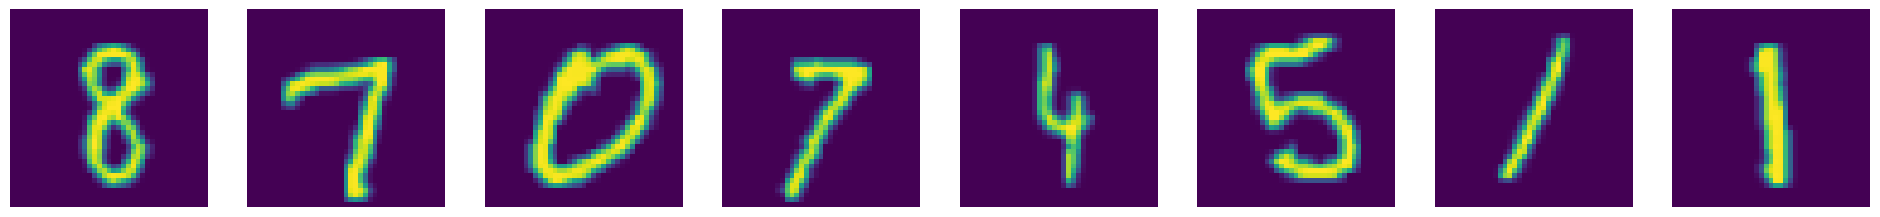

Epoch 0; Training Loss: 5.1211; Test Loss: 5.39141; ran 4.95 sec


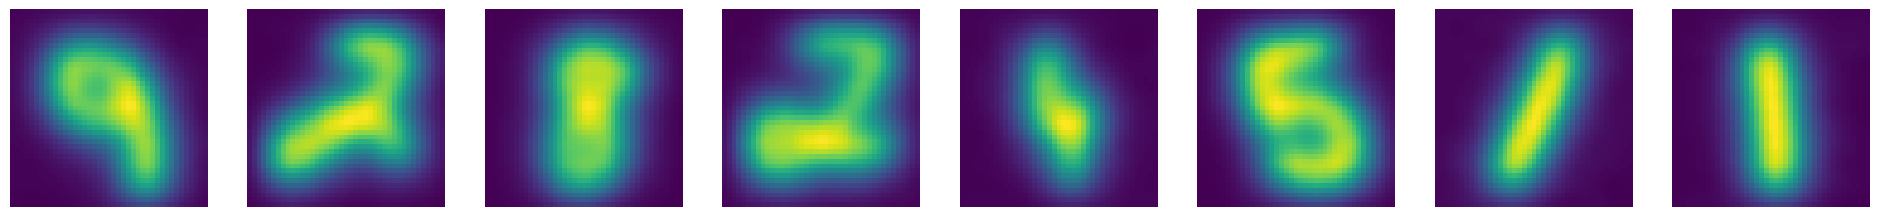

Epoch 50; Training Loss: 0.778805; Test Loss: 0.833815; ran 219.06 sec


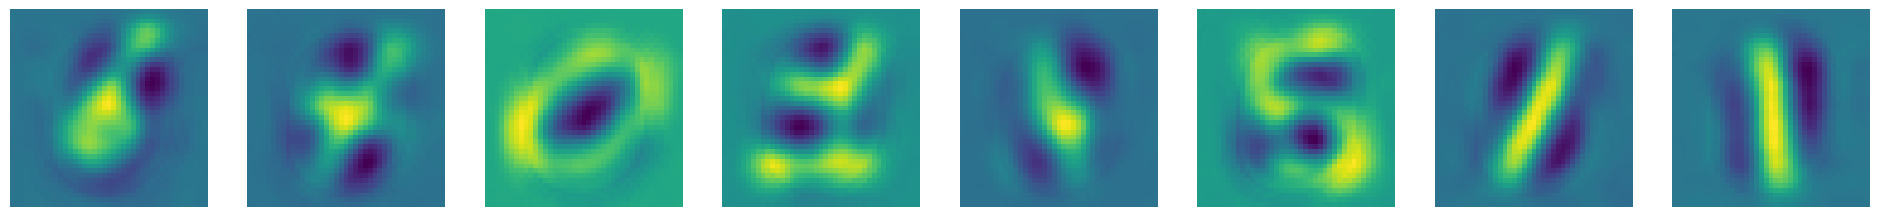

Epoch 100; Training Loss: 0.478191; Test Loss: 0.50746; ran 223.89 sec


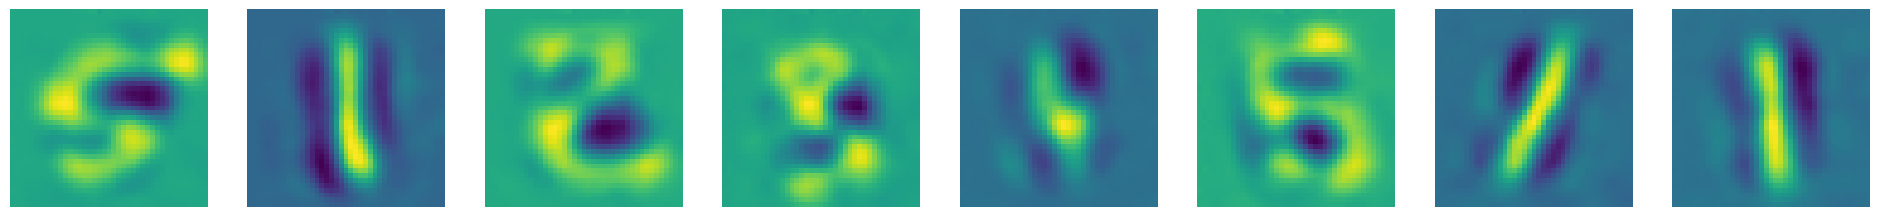

Epoch 150; Training Loss: 0.328289; Test Loss: 0.347551; ran 244.50 sec


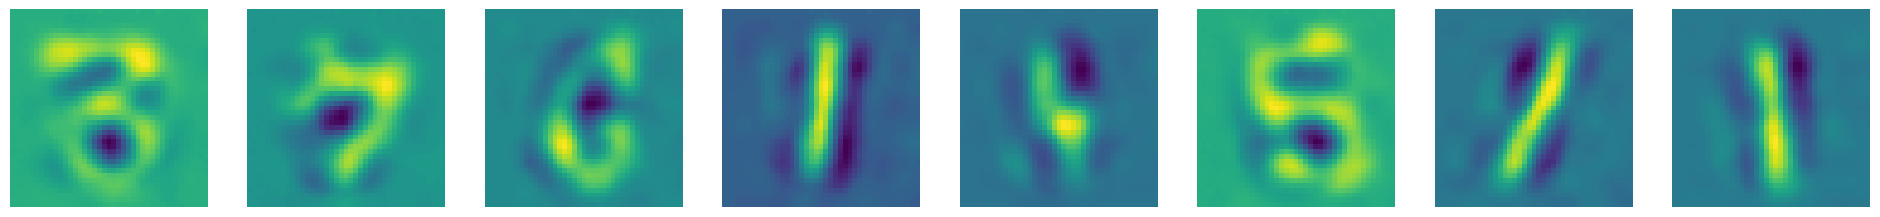

Epoch 200; Training Loss: 0.236659; Test Loss: 0.25139; ran 242.78 sec


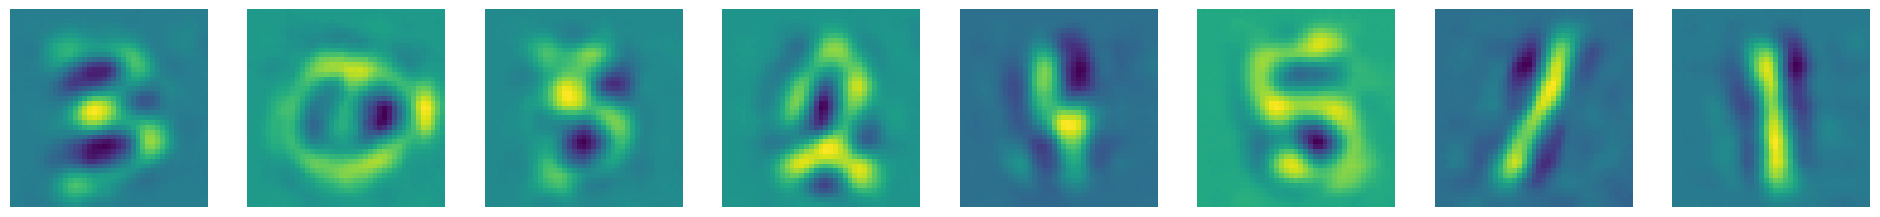

Epoch 250; Training Loss: 0.176068; Test Loss: 0.187711; ran 214.03 sec


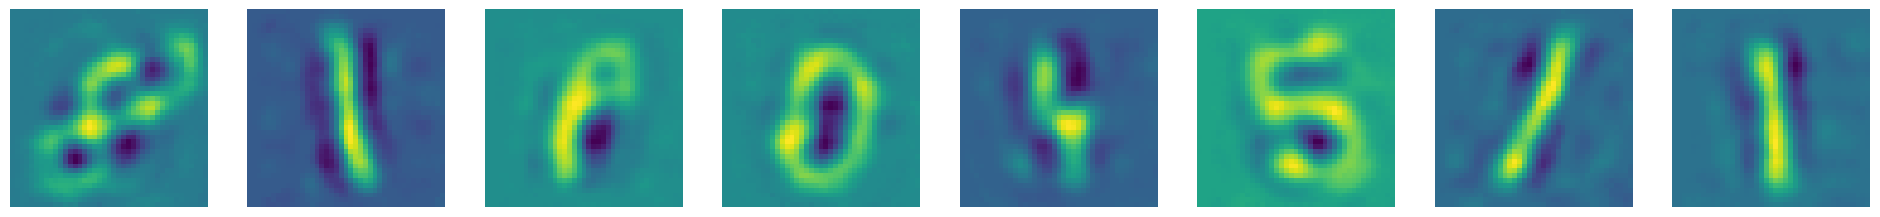

Epoch 300; Training Loss: 0.133743; Test Loss: 0.143541; ran 227.54 sec


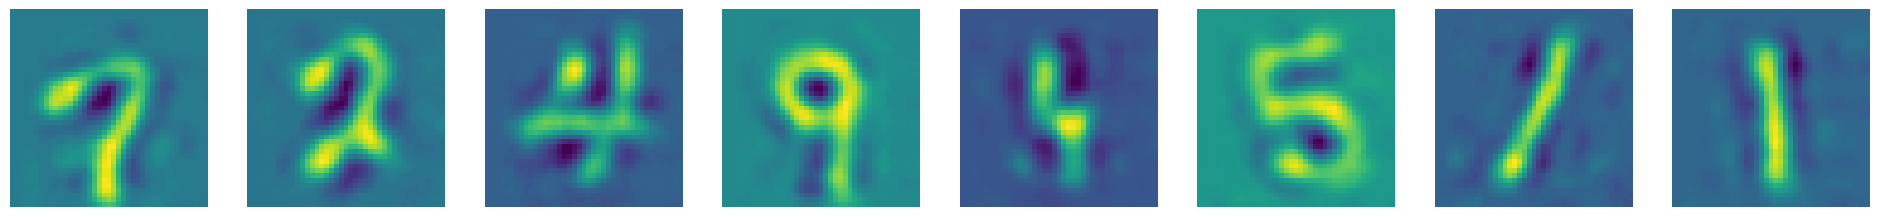

Epoch 350; Training Loss: 0.104849; Test Loss: 0.113466; ran 214.69 sec


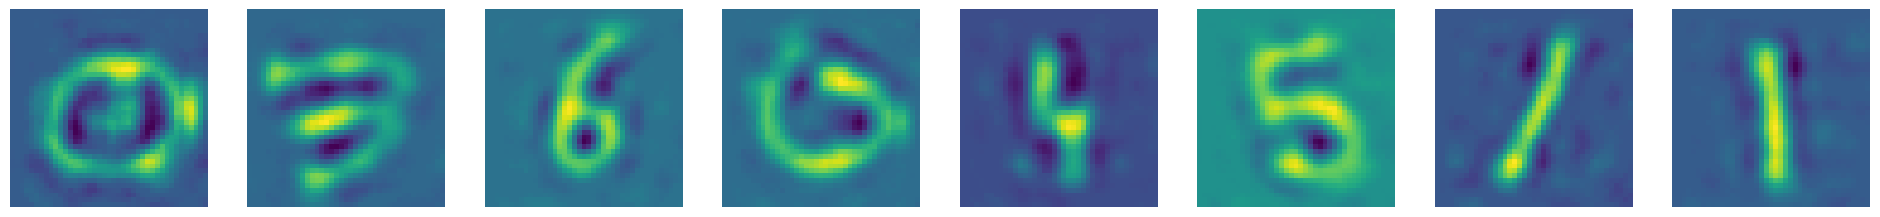

Epoch 400; Training Loss: 0.0844099; Test Loss: 0.0919261; ran 214.90 sec


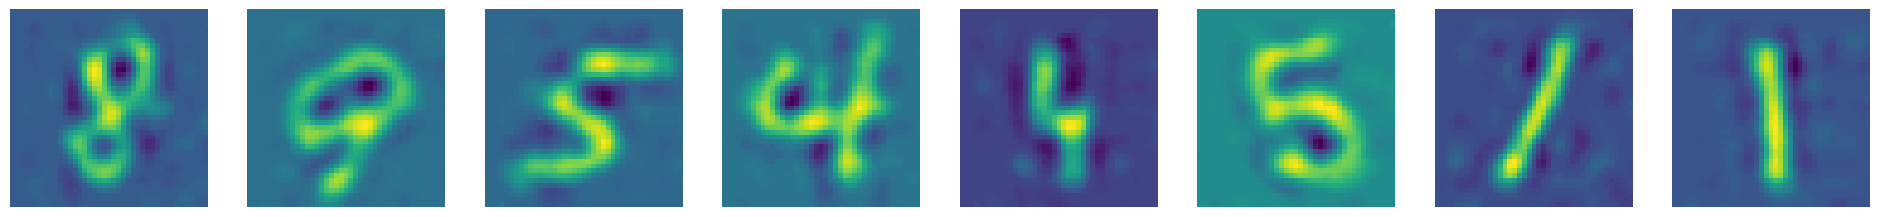

Epoch 450; Training Loss: 0.0703135; Test Loss: 0.0772514; ran 211.62 sec


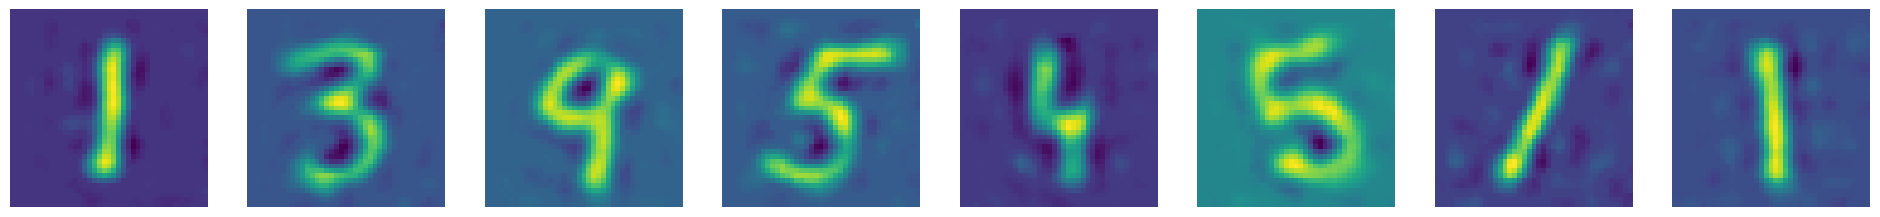

Epoch 500; Training Loss: 0.0604317; Test Loss: 0.0666622; ran 220.49 sec


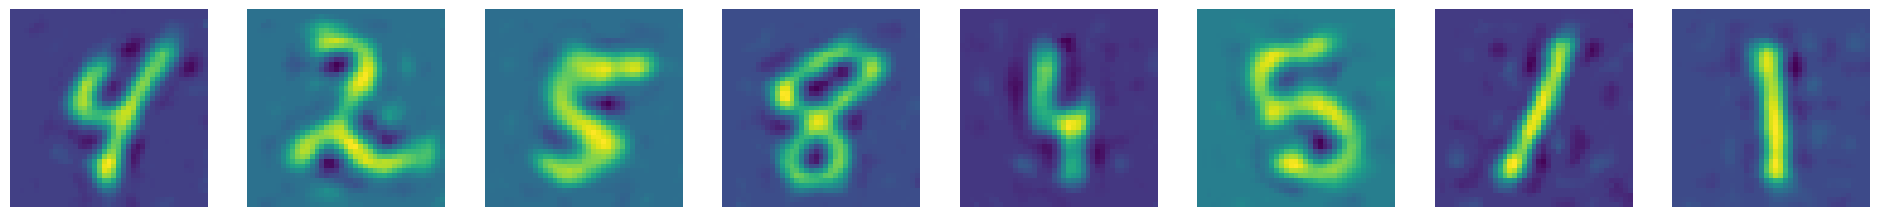

Epoch 550; Training Loss: 0.0534326; Test Loss: 0.0594581; ran 254.88 sec


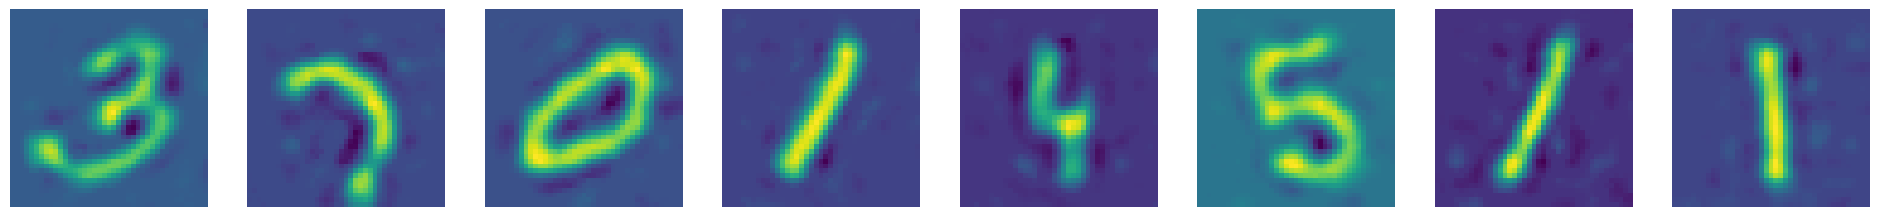

Epoch 600; Training Loss: 0.0490064; Test Loss: 0.0540606; ran 225.88 sec


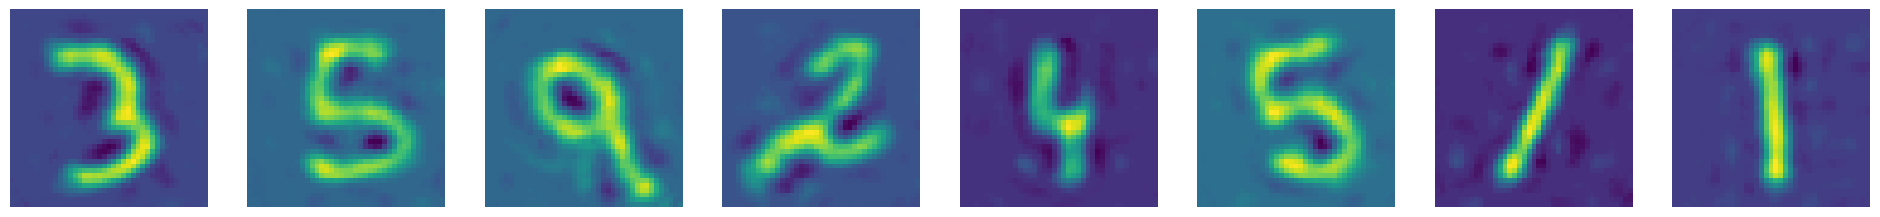

Epoch 650; Training Loss: 0.0440627; Test Loss: 0.0499188; ran 212.59 sec


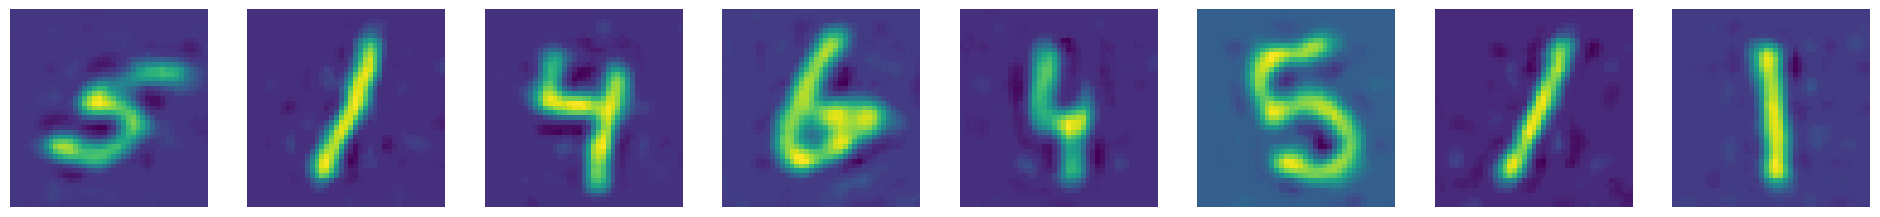

Epoch 700; Training Loss: 0.0417471; Test Loss: 0.0455417; ran 202.50 sec


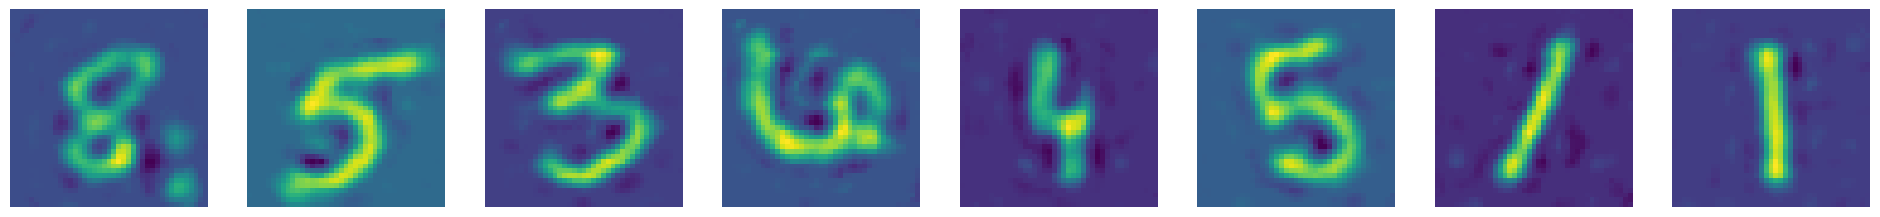

Epoch 750; Training Loss: 0.0387772; Test Loss: 0.0437317; ran 198.30 sec


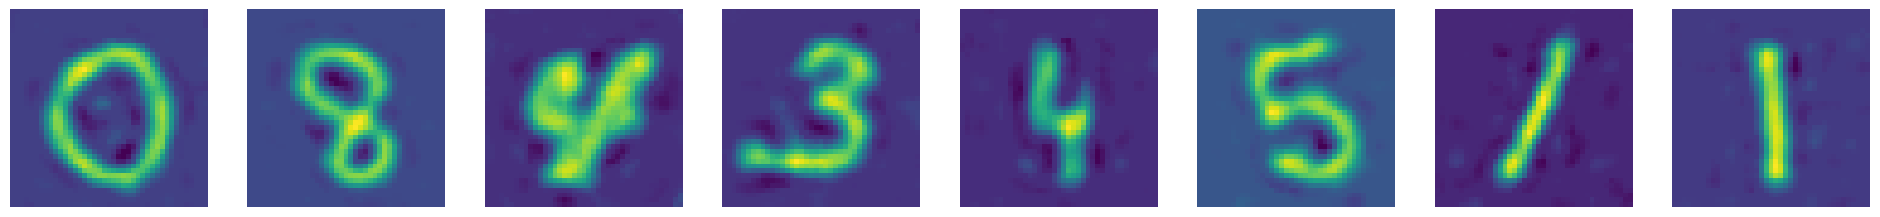

Epoch 800; Training Loss: 0.0367908; Test Loss: 0.0422278; ran 204.46 sec


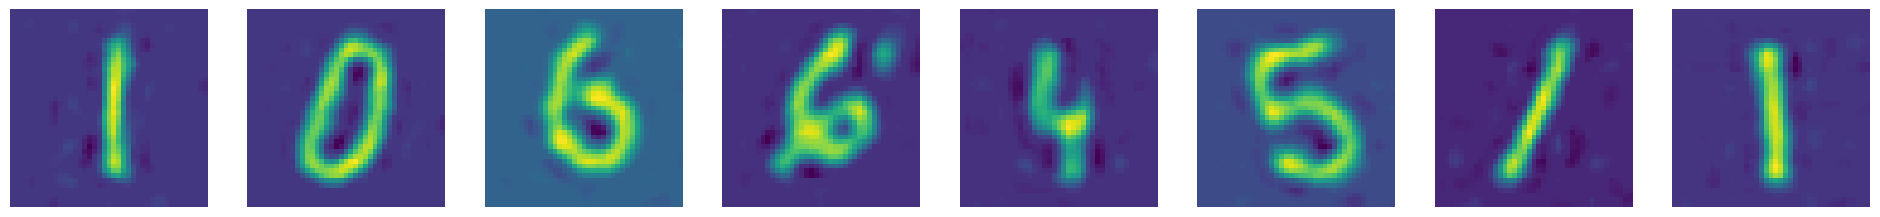

Epoch 850; Training Loss: 0.0350744; Test Loss: 0.0397454; ran 200.67 sec


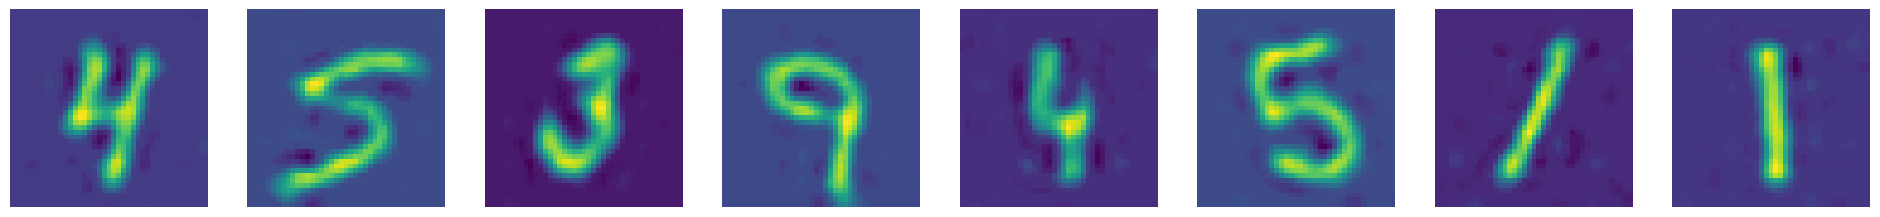

Epoch 900; Training Loss: 0.0338567; Test Loss: 0.0382541; ran 181.49 sec


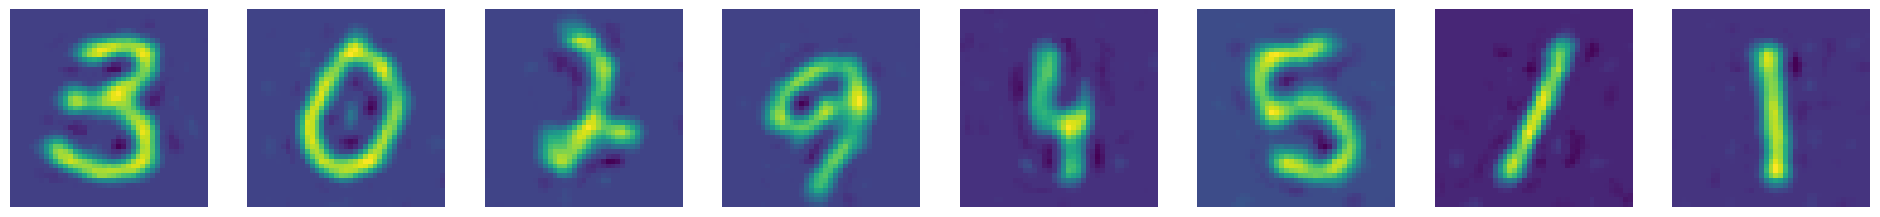

Epoch 950; Training Loss: 0.0328217; Test Loss: 0.0376212; ran 187.06 sec


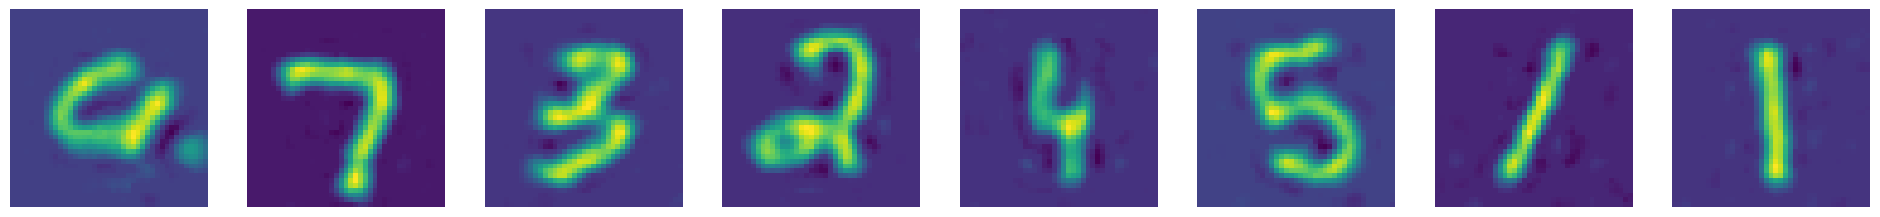

Epoch 1000; Training Loss: 0.0318127; Test Loss: 0.0362064; ran 189.26 sec


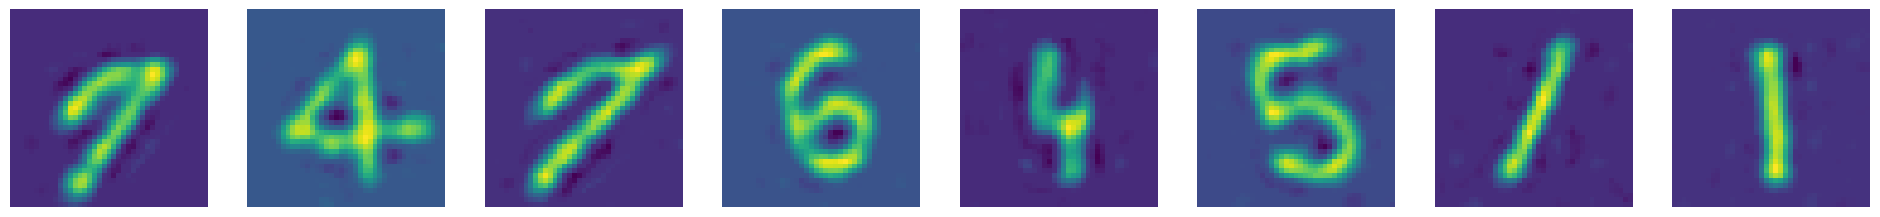

Epoch 1050; Training Loss: 0.031281; Test Loss: 0.0361783; ran 205.19 sec


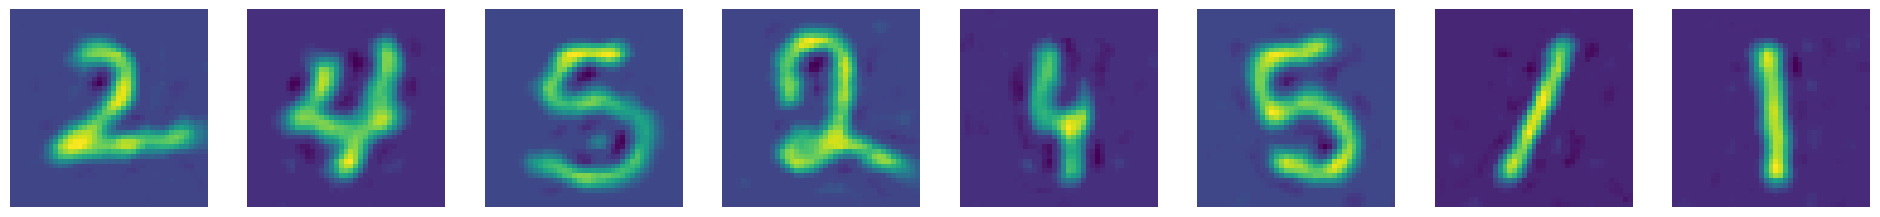

Epoch 1100; Training Loss: 0.0301596; Test Loss: 0.0351909; ran 200.47 sec


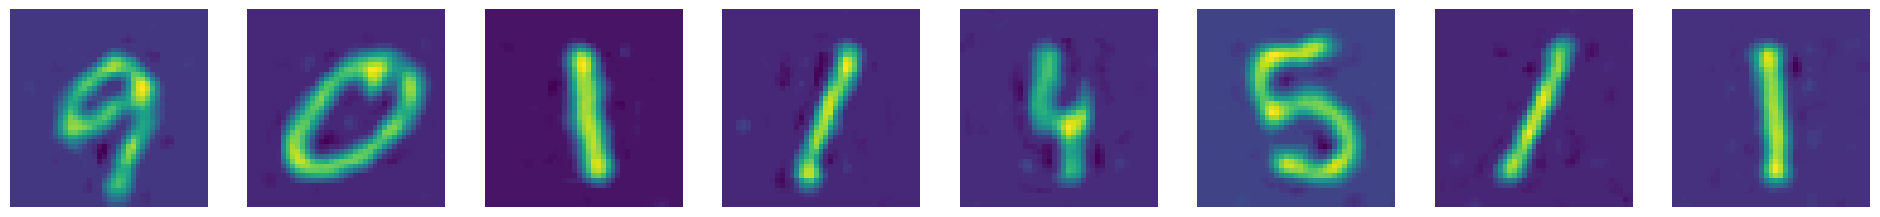

Epoch 1150; Training Loss: 0.0295873; Test Loss: 0.0346427; ran 193.64 sec


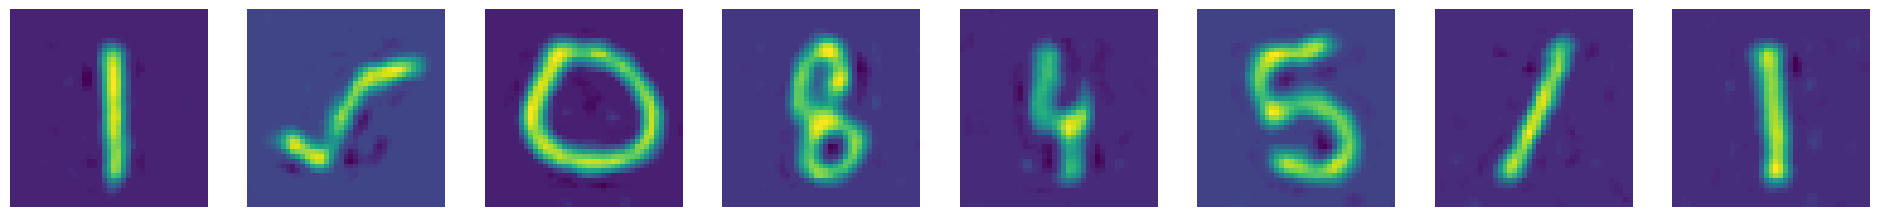

Epoch 1200; Training Loss: 0.0290567; Test Loss: 0.0344088; ran 194.78 sec


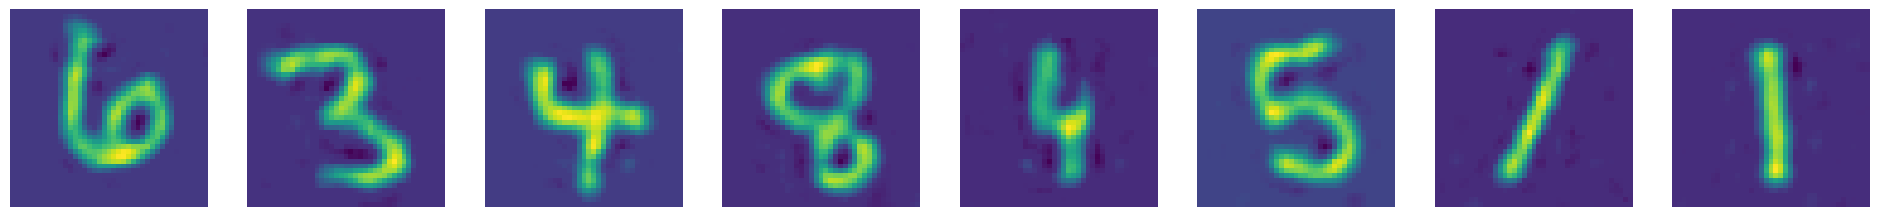

Epoch 1250; Training Loss: 0.0287609; Test Loss: 0.0346726; ran 191.66 sec


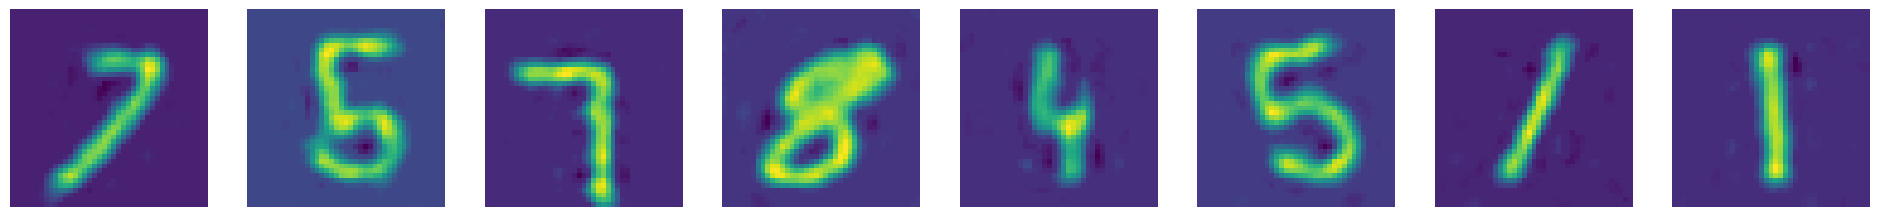

Epoch 1300; Training Loss: 0.0279751; Test Loss: 0.0325342; ran 197.33 sec


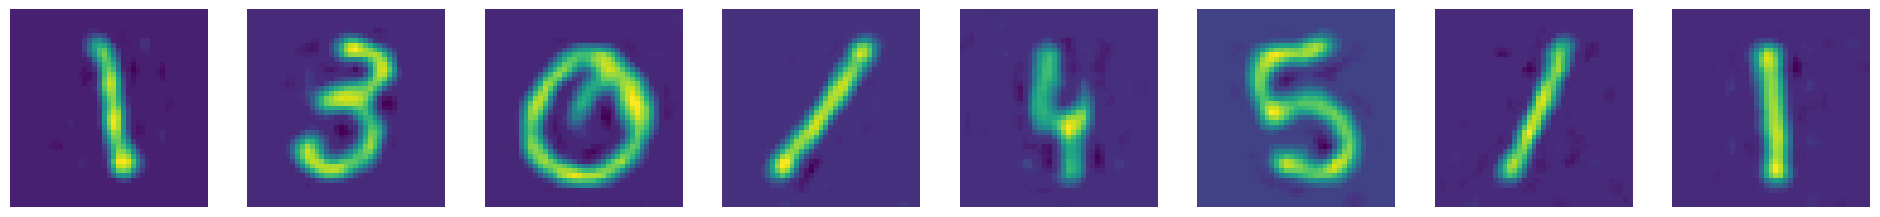

Epoch 1350; Training Loss: 0.0276727; Test Loss: 0.0324648; ran 190.40 sec


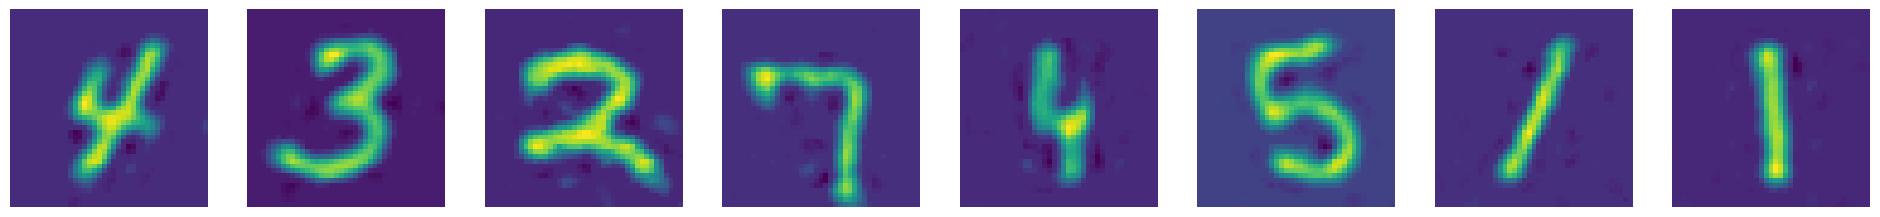

Epoch 1400; Training Loss: 0.0272656; Test Loss: 0.0326035; ran 183.57 sec


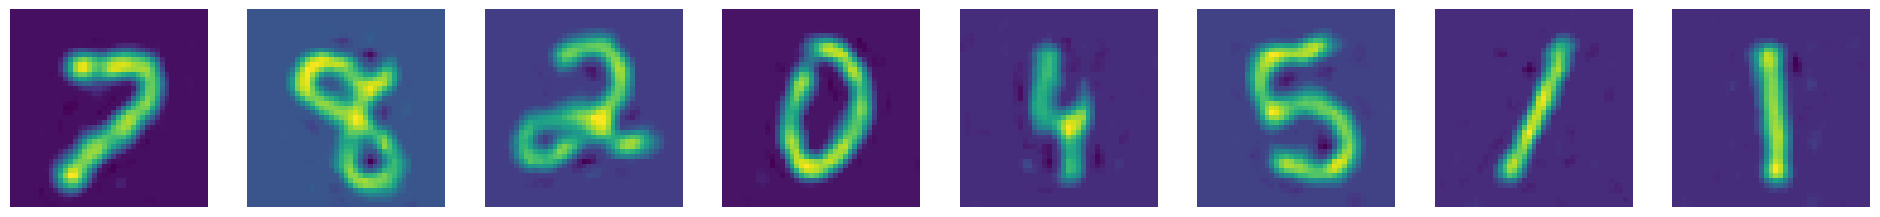

Epoch 1450; Training Loss: 0.0268369; Test Loss: 0.0324891; ran 171.54 sec


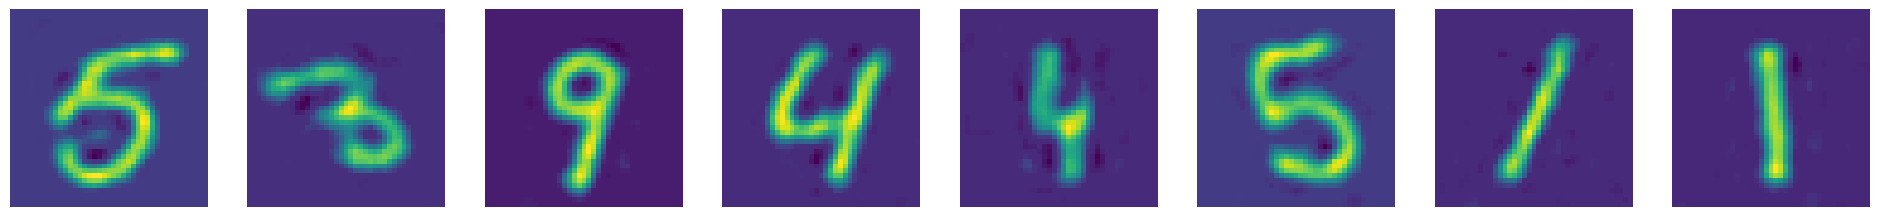

Epoch 1500; Training Loss: 0.0265136; Test Loss: 0.0313888; ran 172.90 sec


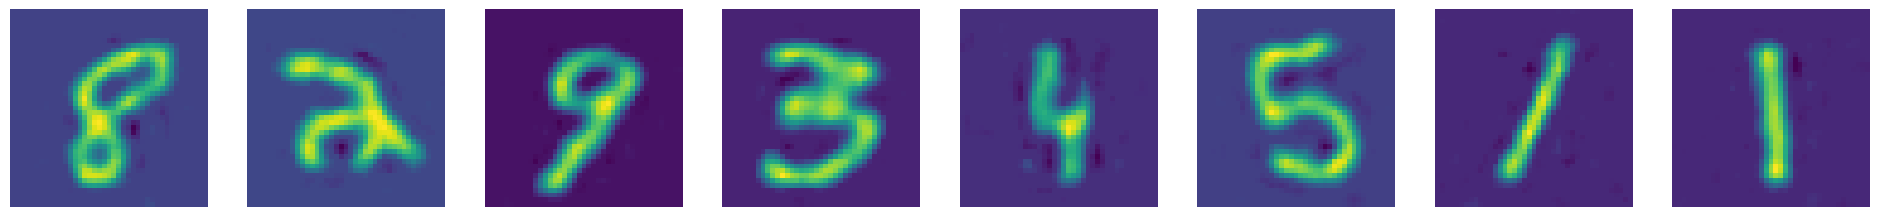

Epoch 1550; Training Loss: 0.026276; Test Loss: 0.0319179; ran 175.63 sec


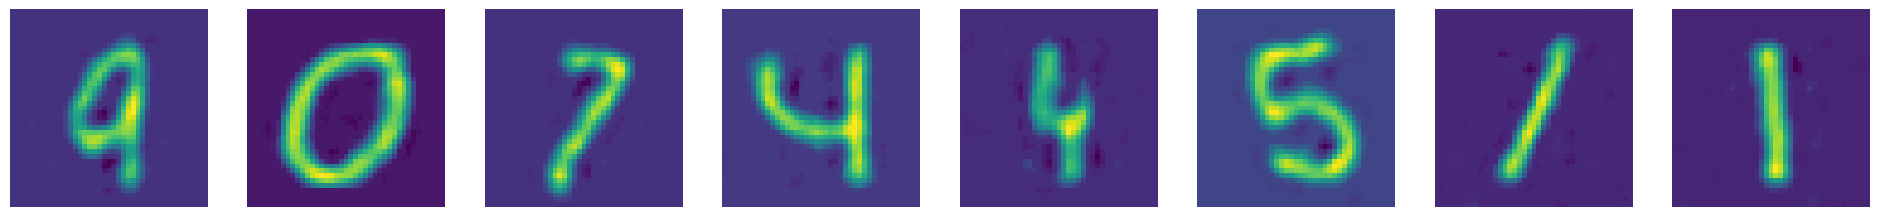

Epoch 1600; Training Loss: 0.0257491; Test Loss: 0.0315558; ran 176.26 sec


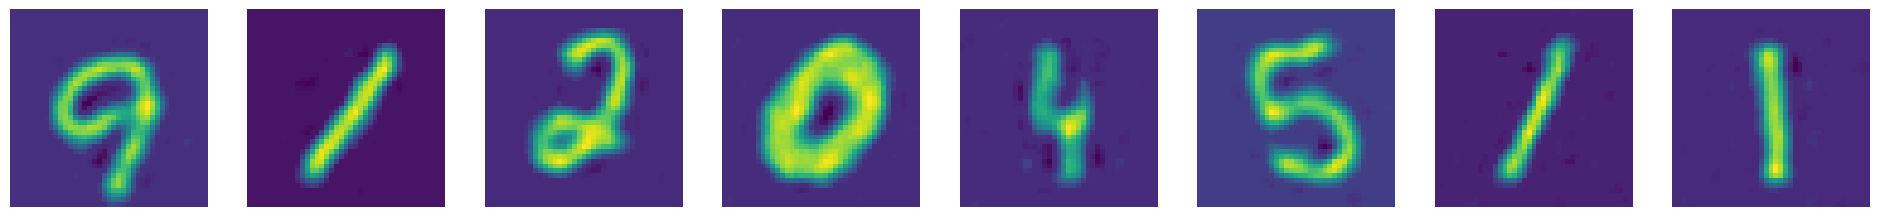

Epoch 1650; Training Loss: 0.0255772; Test Loss: 0.0309243; ran 174.87 sec


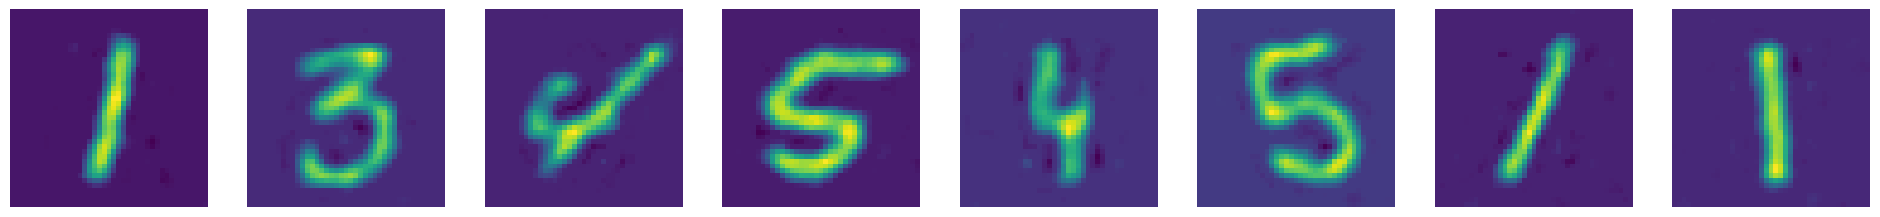

Epoch 1700; Training Loss: 0.0253218; Test Loss: 0.0313149; ran 180.18 sec


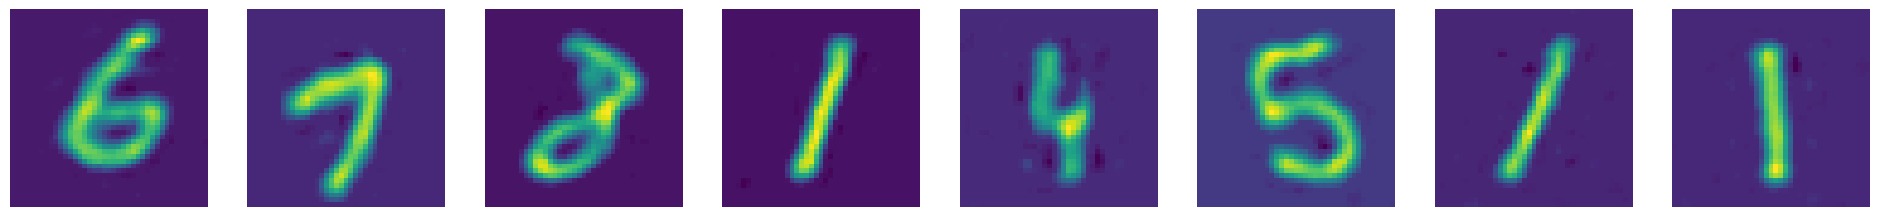

Epoch 1750; Training Loss: 0.0249909; Test Loss: 0.0297177; ran 184.18 sec


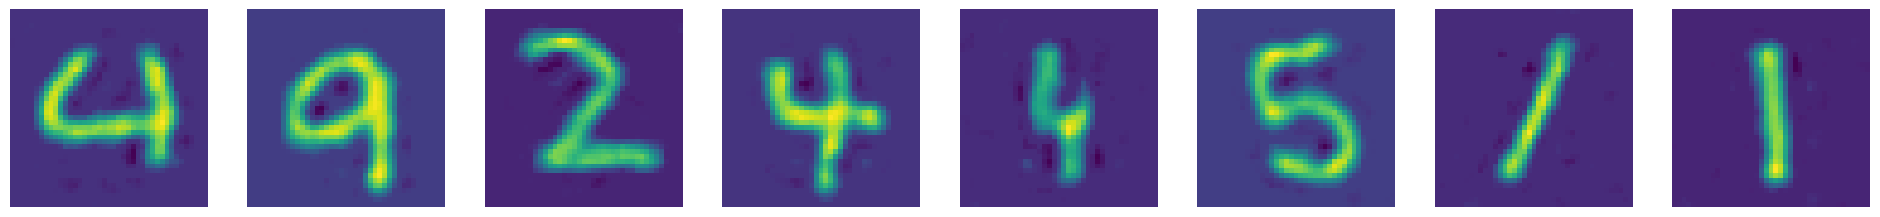

Epoch 1800; Training Loss: 0.024659; Test Loss: 0.030545; ran 190.31 sec


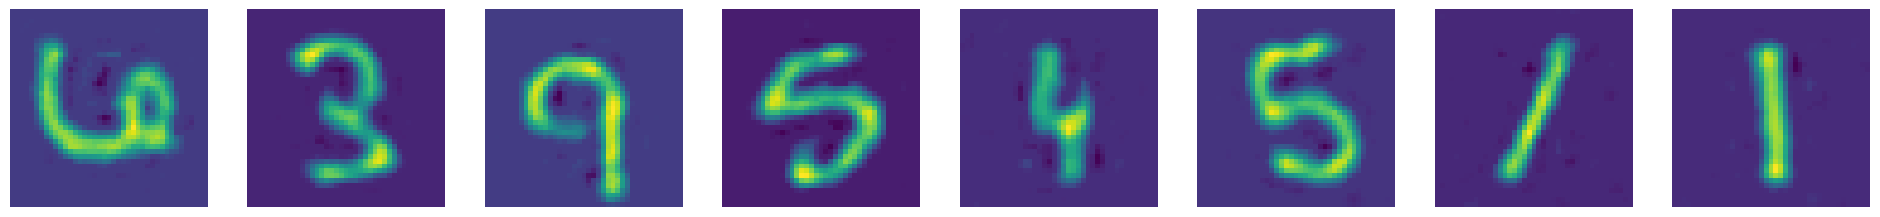

Epoch 1850; Training Loss: 0.0246919; Test Loss: 0.0300422; ran 206.04 sec


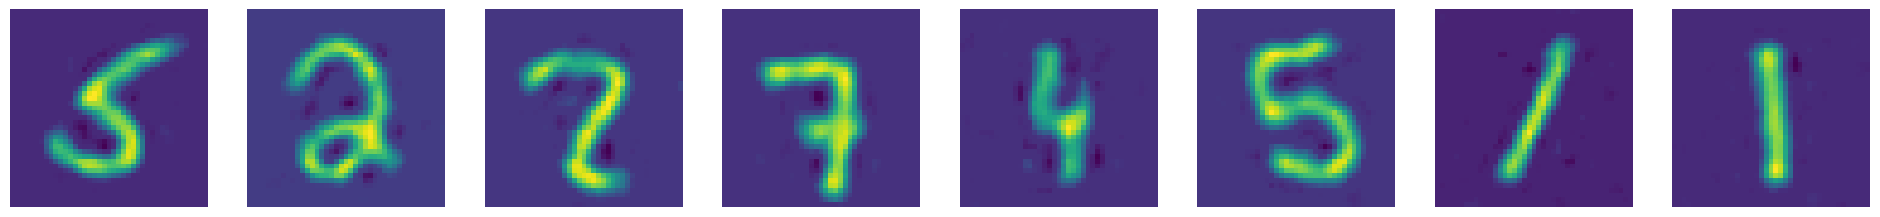

Epoch 1900; Training Loss: 0.024036; Test Loss: 0.0301908; ran 188.76 sec


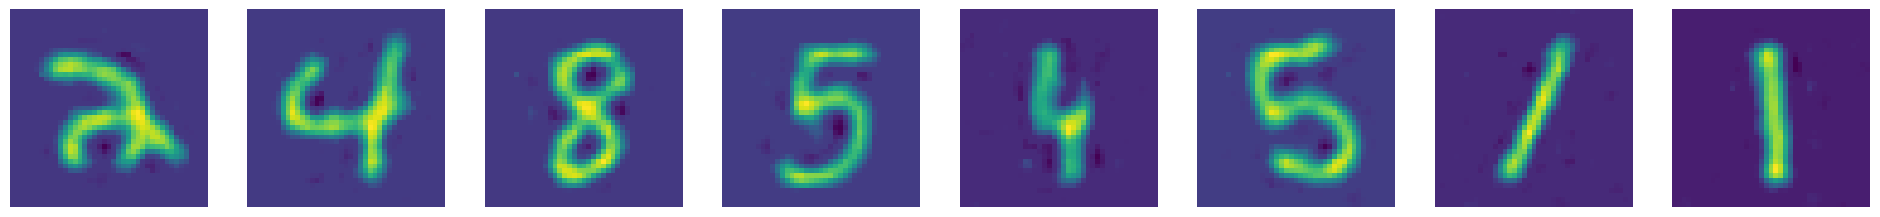

Epoch 1950; Training Loss: 0.0238926; Test Loss: 0.0300877; ran 195.80 sec


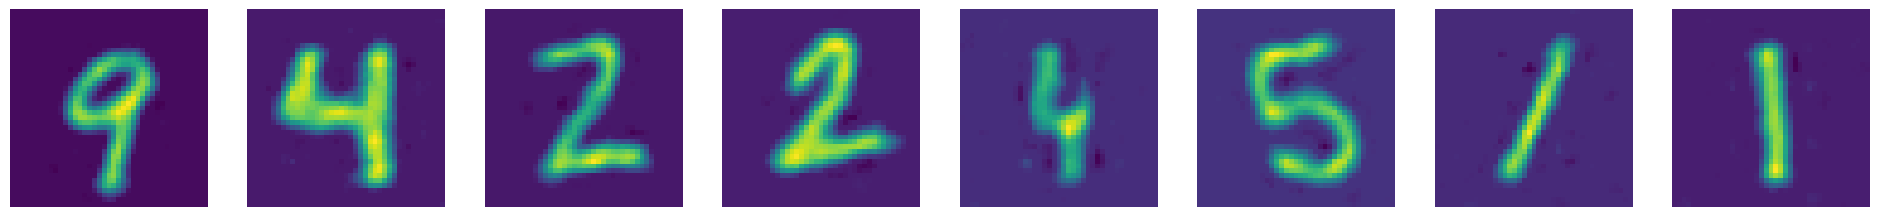

Epoch 1999; Training Loss: 0.0239253; Test Loss: 0.0300279; ran 216.52 sec


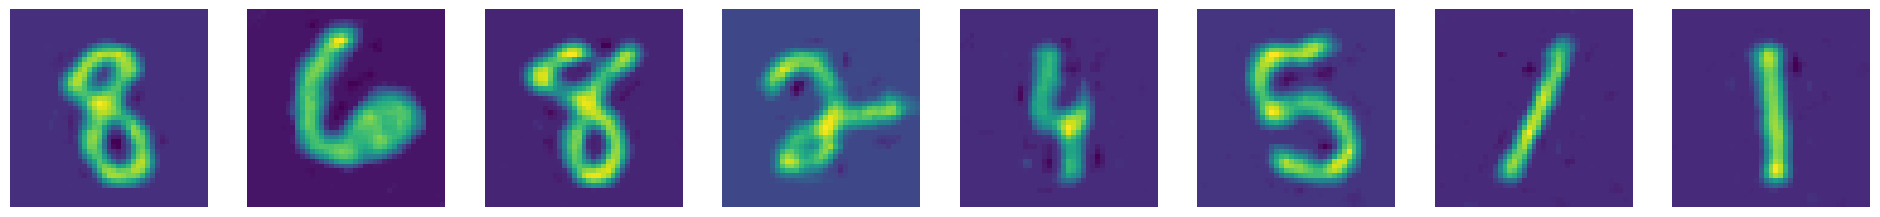

In [36]:
# Train model

# Send to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Set learning parameters
train_dict = {"nLayers": nLayers,
              "scale_mag": scale_initial_val,
              "lam1": lam1,
              "LR": LR,
              "batch_sz": batch_sz,
              "nEpochs": nEpochs,
              "showEvery": showEvery,
              "untied": untied,
              "lossFunc": lossFunc,
              "vgg_weight": vgg_weight,
              "unet_nfilts": unet_nfilts,}
    
model, epoch_arr, train_losses, test_losses, misc_out = train_model(full_dataset, train_dict, device, A=J_mat_np, visInds=displayIndices)

Final reconstructions with clipping


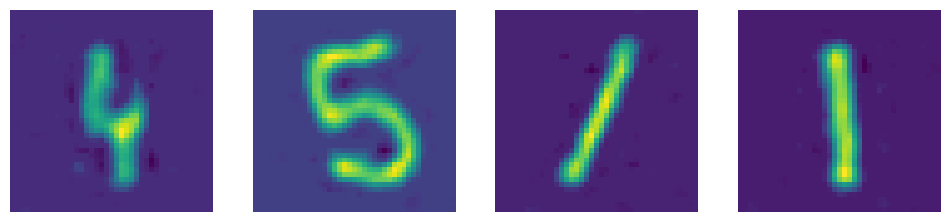

In [37]:
# Generate final results:

min_thresh = 0.0

testMeas, testTruth = full_dataset.getFullTestSet()
trainMeas, trainTruth = full_dataset.getFullTrainSet()

cpu_dev = 'cpu'
model.to(cpu_dev)

with torch.no_grad():
    if unet_nfilts > 0:
        unet = misc_out["unet"]
        unet.send2dev(cpu_dev)
        X_test_torch = unet(model(testMeas.to(cpu_dev)))
        
#         X_train_torch = unet(model(trainMeas.to(device)))
        import math
        nBatches = math.ceil(nTrain / batch_sz)
        X_train_torch = torch.zeros(VOX_W*VOX_L, nTrain)
        for b in range(nBatches):
            b_start = b*batch_sz
            b_end = (b+1)*batch_sz
            X_train_torch[:,b_start:b_end] = unet(model(trainMeas[:,b_start:b_end].to(cpu_dev)))
    else:
        X_test_torch = model(testMeas.to(cpu_dev))
        X_train_torch = model(trainMeas.to(cpu_dev))
    
    meas_test_np = testMeas.cpu().detach().numpy()
    recon_test_np = np.reshape(X_test_torch.cpu().detach().numpy(), (VOX_W, VOX_L, -1))
    truth_test_np = np.reshape(testTruth.cpu().detach().numpy(), (VOX_W, VOX_L, -1))
    
    meas_train_np = trainMeas.cpu().detach().numpy()
    recon_train_np = np.reshape(X_train_torch.cpu().detach().numpy(), (VOX_W, VOX_L, -1))
    truth_train_np = np.reshape(trainTruth.cpu().detach().numpy(), (VOX_W, VOX_L, -1))

print("Final reconstructions with clipping")
final_recon_vis = recon_test_np[:,:,displayIndices]
showIms(final_recon_vis)

In [38]:
# Save results

savepath = os.path.join(resultpath, 'sim')

if not (os.path.isdir(savepath)):
    os.makedirs(savepath)

if untied:
    untied_str = 'T'
else:
    untied_str = 'F'
if vgg_weight > 0:
    vgg_str = 'T'
else:
    vgg_str = 'F'
model_savename = "model_%s_train=%s_test=%s_NL=%d_nEpoch=%d_lossFunc=%s_untied=%s_vgg=%s_unet_nfilts=%d" % (jac_dir, train_set_select, test_set_select, nLayers, nEpochs, lossFunc, untied_str, vgg_str, unet_nfilts)
    
fullsavepath_model = os.path.join(savepath, model_savename + '.pt')
fullsavepath_mat = os.path.join(savepath, model_savename + '.mat')

pydict = {
    "train_dict": train_dict,
    "model": model,
    "epoch_arr": epoch_arr, 
    "train_losses": train_losses,
    "test_losses": test_losses,
    "full_dataset": full_dataset,
}

for k in misc_out:
    pydict[k] = misc_out[k]

matdict = {
    "meas_test_np": meas_test_np,
    "recon_test_np": recon_test_np,
    "truth_test_np": truth_test_np,
    "meas_train_np": meas_train_np,
    "recon_train_np": recon_train_np,
    "truth_train_np": truth_train_np,
    "epoch_arr": epoch_arr, 
    "train_losses": train_losses,
    "test_losses": test_losses,
    
}

torch.save(pydict, fullsavepath_model)
savemat(fullsavepath_mat, matdict)

print("Saved model to: %s" % fullsavepath_model)

Saved model to: /Users/prajakta/Library/CloudStorage/OneDrive-UCB-O365/Unrolled-DOT/results/sim/model_5_1_22_unrolled_jac_train=m_test=m_NL=3_nEpoch=2000_lossFunc=MAE_untied=T_vgg=F_unet_nfilts=0.pt
